# **Main Objective**

The main objective is to practice knowledge of Data Analysis, Machine Learning and Statistics, using specifically time data. For this, a Business Process Intelligence (BPI) data set was selected.

# **About Dataset**

The dataset was found on the [website](https://www.win.tue.nl/bpi/doku.php?id=2017:challenge) of the 13th International Business Process Intelligence Workshop 2017.

The logs refer to a loan application process of a Dutch financial institute. The data includes all the loan process logs including offers made by the company for accepted loan applications.

For more information about the data, you can consult the [event page](https://www.win.tue.nl/bpi/doku.php?id=2017:challenge) in the 'The Data' section or directly in the [page](https://data.4tu.nl/articles/BPI_Challenge_2017/12696884) of the dataset.

# **Analyzes and predictions**


Some questions that can answer possible problems in the process:

*Question 1:How many applications are created per week?*

*Question 2: What is the total number of successful applications per week?*

*Question 3: Per week, what is the average number of events that occurred until the application was successfully completed?*

*Question 4: How long (in weeks) did each application last that was successfully completed?*

*Question 5: Will the application be finalized this week?*

# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# **Loading Data**

In [2]:
bpi_challenge_2017_data = pd.read_csv('../input/bpichallenge2017/BPI_Challenge_2017.csv') 

# **Viewing the data**

In [3]:
bpi_challenge_2017_data.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
bpi_challenge_2017_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202267 entries, 0 to 1202266
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Action                 1202267 non-null  object 
 1   org:resource           1202267 non-null  object 
 2   concept:name           1202267 non-null  object 
 3   EventOrigin            1202267 non-null  object 
 4   EventID                1202267 non-null  object 
 5   lifecycle:transition   1202267 non-null  object 
 6   time:timestamp         1202267 non-null  object 
 7   case:LoanGoal          1202267 non-null  object 
 8   case:ApplicationType   1202267 non-null  object 
 9   case:concept:name      1202267 non-null  object 
 10  case:RequestedAmount   1202267 non-null  float64
 11  FirstWithdrawalAmount  42995 non-null    float64
 12  NumberOfTerms          42995 non-null    float64
 13  Accepted               42995 non-null    object 
 14  MonthlyCost       

# **Checking missing value**

In [5]:
bpi_challenge_2017_data.isnull().sum().sort_values(ascending=False)

CreditScore              1159272
Selected                 1159272
MonthlyCost              1159272
Accepted                 1159272
NumberOfTerms            1159272
FirstWithdrawalAmount    1159272
OfferedAmount            1159272
OfferID                  1051413
lifecycle:transition           0
org:resource                   0
concept:name                   0
EventOrigin                    0
EventID                        0
case:concept:name              0
time:timestamp                 0
case:LoanGoal                  0
case:ApplicationType           0
case:RequestedAmount           0
Action                         0
dtype: int64

We can see that there are a large number of rows with columns with missing values. Depending on the analyzes to be performed, these columns need to be filled in or else the row or column can be removed. For these analyzes one of the most important columns is "time: timestamp", which we can see that has no missing value.

# **Exploratory Analyzes**

In [6]:
df_temporal_exp = bpi_challenge_2017_data.copy()
df_temporal_exp.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creation of a new column to store the time in 'datetime' format for better handling.

In [7]:
df_temporal_exp['datetime'] = pd.to_datetime(df_temporal_exp['time:timestamp'])
df_temporal_exp.sample(2)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime
478335,Deleted,User_113,W_Call incomplete files,Workflow,Workitem_1862870100,ate_abort,2016-06-24 10:12:59.020000+00:00,Extra spending limit,New credit,Application_1422952731,7000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-24 10:12:59.020000+00:00
36032,Released,User_85,W_Call after offers,Workflow,Workitem_357719398,suspend,2016-01-18 08:24:17.705000+00:00,Car,New credit,Application_1519229956,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-18 08:24:17.705000+00:00


Creating the *week* column with the current year and week number of the application

In [8]:
df_temporal_exp['week'] = df_temporal_exp['datetime'].dt.strftime("%G_WK%V")
df_temporal_exp.sample(2)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week
131089,Obtained,User_41,W_Call incomplete files,Workflow,Workitem_1177031913,resume,2016-03-03 09:45:29.156000+00:00,Car,New credit,Application_836222420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 09:45:29.156000+00:00,2016_WK09
1048687,statechange,User_83,O_Refused,Offer,OfferState_1543921519,complete,2016-11-25 08:41:37.371000+00:00,Unknown,New credit,Application_2107501162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_954218779,2016-11-25 08:41:37.371000+00:00,2016_WK47


## **Question 1: How many applications are created per week?**

In [9]:
apps_created = df_temporal_exp[df_temporal_exp['concept:name'] == 'A_Create Application']
apps_created.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,2015_WK53
40,Created,User_1,A_Create Application,Application,Application_1691306052,complete,2016-01-01 10:16:11.500000+00:00,Home improvement,New credit,Application_1691306052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 10:16:11.500000+00:00,2015_WK53
71,Created,User_1,A_Create Application,Application,Application_428409768,complete,2016-01-01 11:19:38.177000+00:00,Home improvement,New credit,Application_428409768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 11:19:38.177000+00:00,2015_WK53
116,Created,User_1,A_Create Application,Application,Application_1746793196,complete,2016-01-01 12:34:53.911000+00:00,Car,New credit,Application_1746793196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 12:34:53.911000+00:00,2015_WK53
200,Created,User_1,A_Create Application,Application,Application_828200680,complete,2016-01-01 13:00:04.360000+00:00,Home improvement,New credit,Application_828200680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 13:00:04.360000+00:00,2015_WK53


In [10]:
apps_created_per_week = apps_created.groupby(['week'])['case:concept:name'].count()
apps_created_per_week.head()

week
2015_WK53    105
2016_WK01    543
2016_WK02    515
2016_WK03    511
2016_WK04    520
Name: case:concept:name, dtype: int64

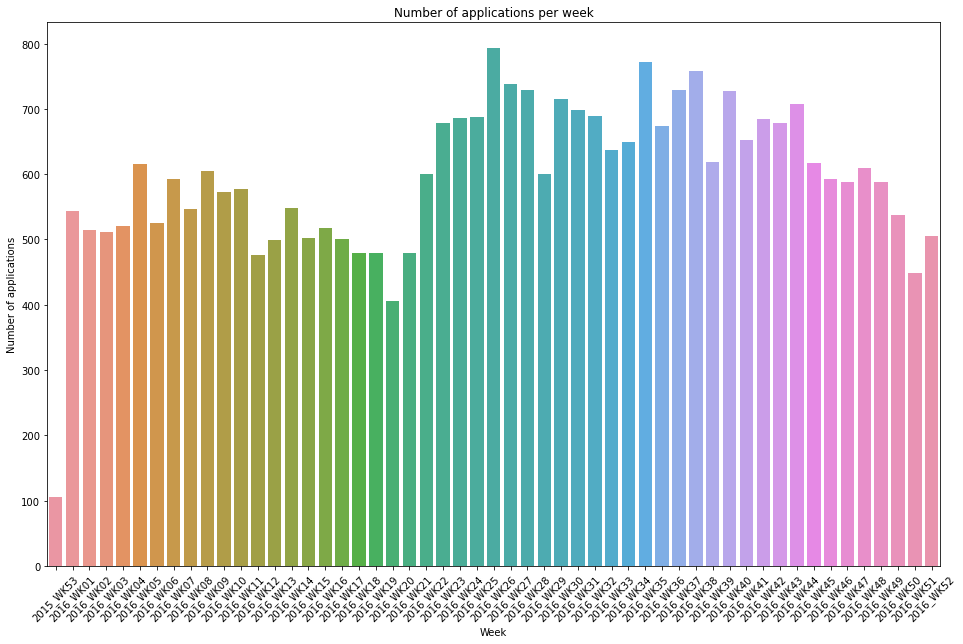

In [11]:
plt.figure(figsize=[16,10])
ax = sns.barplot(x=apps_created_per_week.index, y=apps_created_per_week.values)
ax.set(ylabel="Number of applications", xlabel = "Week")
ax.set_title("Number of applications per week")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

We can see that the weeks with the most new loan applications were the weeks 25, 34 and 37 of 2016. But the variation in the year 2016 was not very large.

## **Question 2: What is the total number of successful applications per week?**

In [12]:
apps_pending = df_temporal_exp[df_temporal_exp['concept:name'] == 'A_Pending']
apps_pending.head()

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week
38,statechange,User_115,A_Pending,Application,ApplState_1179730815,complete,2016-01-14 15:49:11.420000+00:00,Existing loan takeover,New credit,Application_652823628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 15:49:11.420000+00:00,2016_WK02
114,statechange,User_90,A_Pending,Application,ApplState_16917315,complete,2016-01-14 07:00:14.450000+00:00,Home improvement,New credit,Application_428409768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 07:00:14.450000+00:00,2016_WK02
197,statechange,User_95,A_Pending,Application,ApplState_1840619616,complete,2016-01-28 12:18:51.292000+00:00,Car,New credit,Application_1746793196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-28 12:18:51.292000+00:00,2016_WK04
363,statechange,User_119,A_Pending,Application,ApplState_1373444220,complete,2016-01-22 08:03:30.899000+00:00,Car,New credit,Application_619403287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-22 08:03:30.899000+00:00,2016_WK03
428,statechange,User_75,A_Pending,Application,ApplState_788894388,complete,2016-01-27 09:25:38.989000+00:00,"Other, see explanation",New credit,Application_1529124572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-27 09:25:38.989000+00:00,2016_WK04


In [13]:
pendings_per_week = apps_pending.groupby(['week'])['case:concept:name'].count()
pendings_per_week.sample(5)

week
2016_WK20    185
2016_WK32    286
2016_WK47    647
2016_WK07    221
2016_WK33    238
Name: case:concept:name, dtype: int64

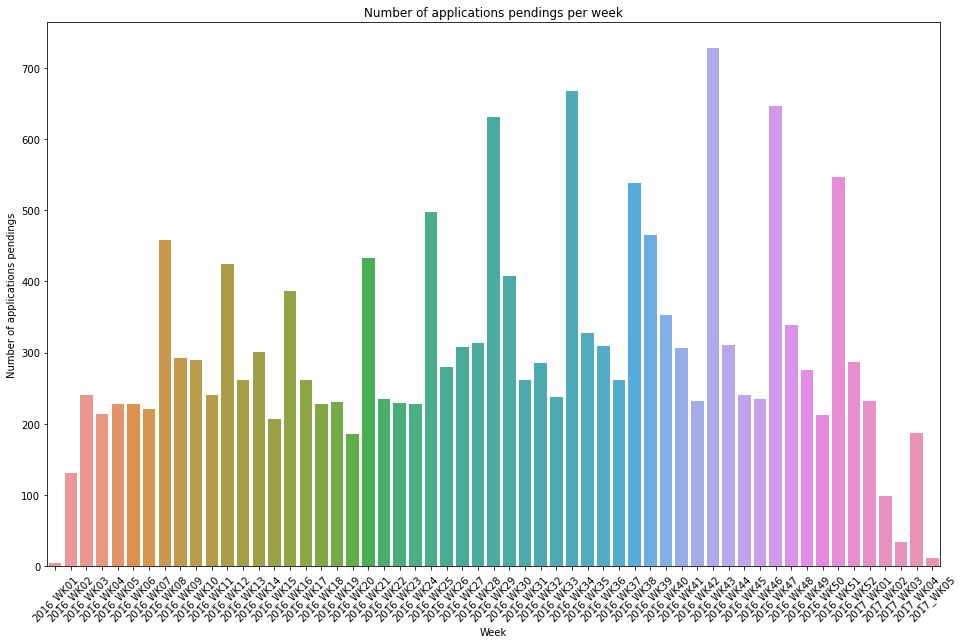

In [14]:
plt.figure(figsize=[16,10])
ax = sns.barplot(x=pendings_per_week.index, y=pendings_per_week.values)
ax.set(ylabel="Number of applications pendings", xlabel = "Week")
ax.set_title("Number of applications pendings per week")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

While the number of new applications per week did not vary much, the number of completed applications (A_Pending) had a greater variation. Week 42 of 2016 had the most applications successfully completed.


## **Question 3: Per week, what is the average number of events that occurred until the application was successfully completed?**

In [15]:
apps_name_pending = df_temporal_exp[df_temporal_exp['concept:name'] == 'A_Pending']['case:concept:name'].drop_duplicates()
events_apps_pending = df_temporal_exp.merge(apps_name_pending, on='case:concept:name')
events_apps_pending.sample(5)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,datetime,week
503750,Obtained,User_41,W_Call after offers,Workflow,Workitem_83491136,resume,2016-09-05 13:37:19.118000+00:00,Existing loan takeover,New credit,Application_269210092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-05 13:37:19.118000+00:00,2016_WK36
374348,statechange,User_38,O_Sent (mail and online),Offer,OfferState_2053775548,complete,2016-07-04 12:00:11.025000+00:00,Car,New credit,Application_304662674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_683362861,2016-07-04 12:00:11.025000+00:00,2016_WK27
204958,Created,User_1,W_Complete application,Workflow,Workitem_1716281282,schedule,2016-04-17 14:37:47.940000+00:00,Car,New credit,Application_1114695992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-17 14:37:47.940000+00:00,2016_WK15
520602,statechange,User_1,A_Submitted,Application,ApplState_1493040336,complete,2016-09-04 17:59:25.452000+00:00,Existing loan takeover,New credit,Application_1226147209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-04 17:59:25.452000+00:00,2016_WK35
90384,Released,User_117,W_Validate application,Workflow,Workitem_109567111,suspend,2016-02-25 13:39:55.973000+00:00,Car,New credit,Application_2078961381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25 13:39:55.973000+00:00,2016_WK08


In [16]:
mean_ev_apps_pending_per_week = (events_apps_pending.groupby(['week','case:concept:name'])['EventID'].count()
                                 .groupby(['week']).mean()
                                 .reset_index()
                                 .rename(index = str, columns = {'EventID': "Mean of events"}))
mean_ev_apps_pending_per_week.sample(5)

,week,Mean of events
19,2016_WK19,15.853254
47,2016_WK47,11.635625
43,2016_WK43,11.167874
8,2016_WK08,13.067325
9,2016_WK09,15.383901


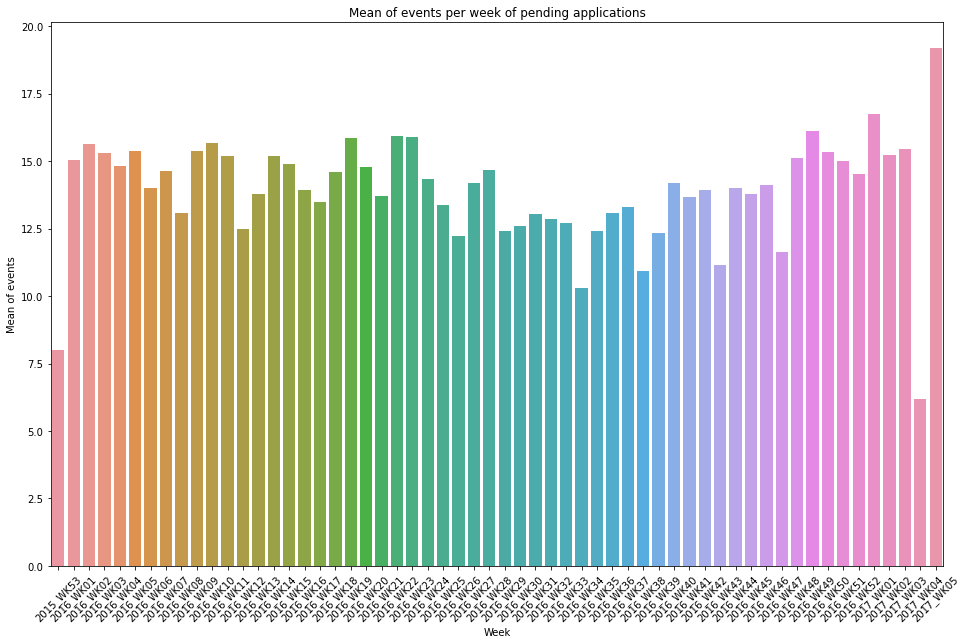

In [17]:
plt.figure(figsize=[16,10])
ax = sns.barplot(x='week', y='Mean of events', data=mean_ev_apps_pending_per_week)
ax.set(ylabel="Mean of events", xlabel = "Week")
ax.set_title("Mean of events per week of pending applications")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

The distribution did not vary much, some weeks had an average of lower logs, but many factors may have influenced, or the process was quick on the side of the company and the client, more applications finished successfully in the previous or next week, among others reasons.

 ## **Question 4: How long (in weeks) did each application last that was completed?**

In [18]:
apps_start_date = (df_temporal_exp[df_temporal_exp['concept:name'] == 'A_Create Application']
                    .filter(['case:concept:name','datetime'])
                    .rename(index=str, columns={'datetime' : 'start_date'}))

apps_end_date = (df_temporal_exp[df_temporal_exp['concept:name'].isin(['A_Cancelled', 'A_Denied', 'A_Pending'])]
                    .filter(['case:concept:name', 'datetime'])
                    .rename(index=str, columns={'datetime': 'end_date'}))
                    
apps_duration = pd.merge(apps_start_date, apps_end_date, how='inner', on='case:concept:name')
apps_duration['num_weeks'] = (apps_duration['end_date'] - apps_duration['start_date']).dt.days/7

apps_duration.filter(['case:concept:name', 'num_weeks']).sample(5)

,case:concept:name,num_weeks
5211,Application_907020089,1.142857
14047,Application_1093757217,3.285714
9772,Application_1964386160,2.000000
24752,Application_286814897,1.714286
27869,Application_1210876281,2.142857


Para uma melhor visualização podemos analisar o número mínimo, máximo e médio de semanas. E também podemos visualizar num gráfico boxplot que consegue mostrar de forma mais claras estas métricas.

In [19]:
apps_duration['num_weeks'].describe().astype(int)

count    31412
mean         3
std          1
min          0
25%          1
50%          2
75%          4
max         24
Name: num_weeks, dtype: int64

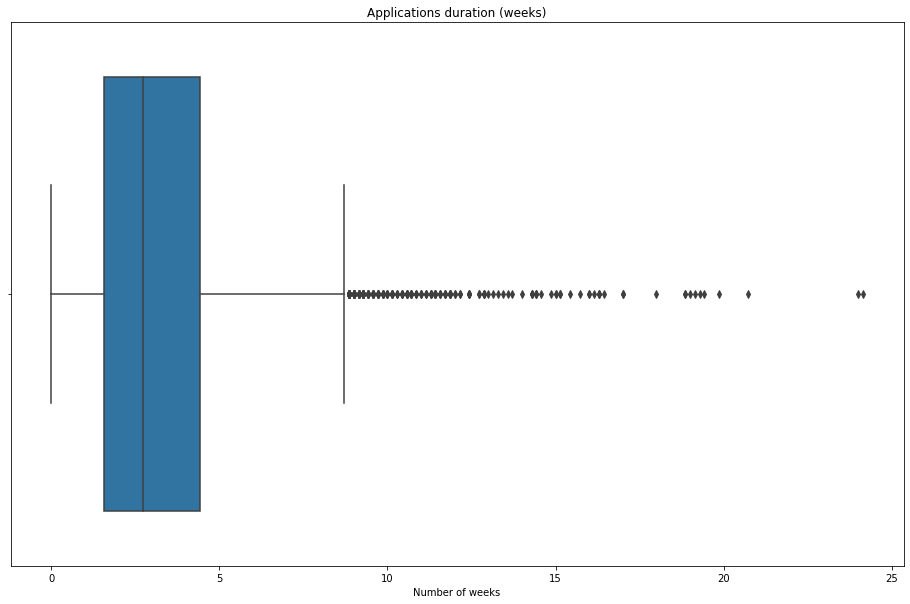

In [20]:
plt.figure(figsize=[16,10])
ax = sns.boxplot(x=apps_duration['num_weeks'])
ax.set_title('Applications duration (weeks)')
ax.set_xlabel('Number of weeks')
plt.show()

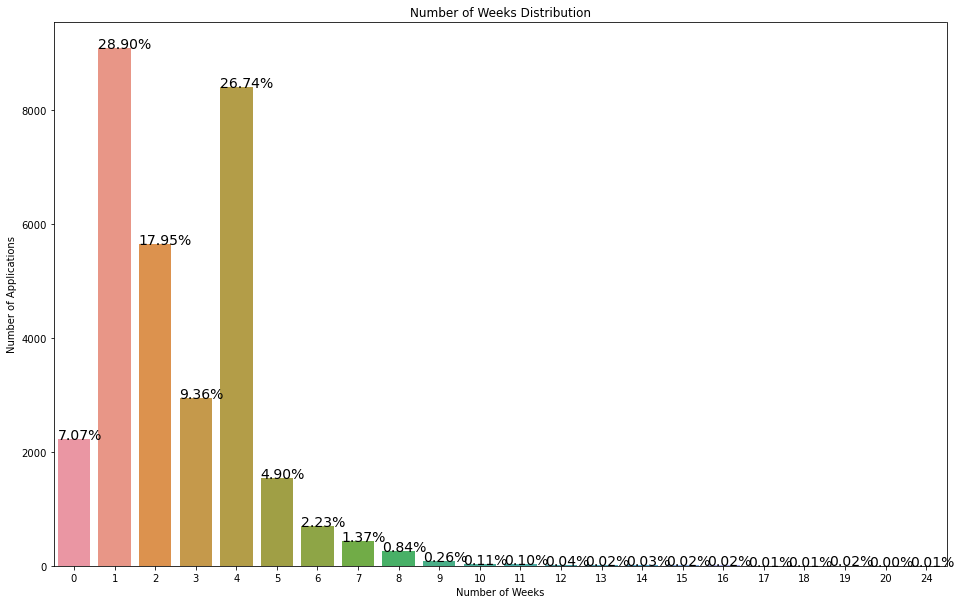

In [21]:
plt.figure(figsize=[16,10])
num_weeks = apps_duration['num_weeks'].astype(int)
ax = sns.countplot(num_weeks)
for p in ax.patches:
    (ax.annotate('{:.2f}%'.format(p.get_height()/len(num_weeks)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set_title("Number of Weeks Distribution")
ax.set(xlabel="Number of Weeks", ylabel="Number of Applications")
plt.show()

The bar graph shows the distribution of the number of weeks and the percentage that an application lasted until it completed successfully. A small percentage lasted for about 24 weeks (an average of 168 days), but most range from 1 to 4 weeks.

# **Classification**

## **Question 5: Will the application be finalized this week?**

To answer this question we have to predict something in the future and for this case we can use the Classification.

As the variable to be predicted is a future value, it indicates that it is a temporal variable, which is not a fixed target, as it will depend on temporal variables for it to happen, that is, it can vary in a timeline.

## **Selecting features**

The following input variables (features) were chosen:

* quarter: Current week year period of the application
* month: Current month of the application
* duration: Duration (in days) of application until the end of the previous week
* events_accum: Number of events until the end of the current week
* events_qty: Number of offers until the last day of the previous week
* offer_accum: Number of events until the end of the current week
* offer_qty: Number of offers for the application until the last day of the previous week

These features are temporal and need to be created.

## **Structuring the data**

Some columns will not be necessary for the model, so we can create a new data set with just the columns that we will need to create the features.

In [22]:
df_temporal = df_temporal_exp[['datetime', 'case:concept:name', 'concept:name', 'EventID']].copy(deep=True)
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571


Creating the column *start_week* that will keep the date of Monday, representing the current week.

In [23]:
df_temporal['start_week'] = (df_temporal['datetime']
                             .apply(lambda x : x - timedelta(x.dayofweek))
                             .dt.strftime('%d-%m-%Y'))
df_temporal['start_week'] = df_temporal['start_week'].apply(lambda x : datetime.strptime(x, '%d-%m-%Y'))
df_temporal.sample(2)

,datetime,case:concept:name,concept:name,EventID,start_week
75994,2016-02-04 08:27:35.547000+00:00,Application_927559845,W_Call incomplete files,Workitem_2106592304,2016-02-01
316656,2016-04-26 11:52:46.717000+00:00,Application_566214233,W_Call incomplete files,Workitem_727495407,2016-04-25


**Creating the feature 'quarter' - Current week year period of the application**

In [24]:
df_temporal['quarter'] = df_temporal['datetime'].dt.quarter
                            #.apply(lambda x: '1º Quarter' if x == 1 
                               #else ('2º Quarter' if x == 2 
                                     #else ('3º Quarter' if x == 3 
                                           #else '4º Quarter'))))
df_temporal.sample(5)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter
724115,2016-08-16 14:40:53.129000+00:00,Application_28400715,A_Accepted,ApplState_1564404478,2016-08-15,3
82905,2016-01-29 12:16:33.315000+00:00,Application_2131314372,W_Complete application,Workitem_2052878103,2016-01-25,1
28213,2016-01-26 23:00:28.137000+00:00,Application_1158729550,W_Call incomplete files,Workitem_2024013364,2016-01-25,1
1158329,2016-12-29 09:20:17.871000+00:00,Application_1568412373,W_Validate application,Workitem_612107722,2016-12-26,4
841019,2016-09-30 12:29:42.593000+00:00,Application_1284590362,W_Validate application,Workitem_1914367393,2016-09-26,3


**Creating the feature 'month'- Current month  of the application**

In [25]:
df_temporal['month'] =  df_temporal['datetime'].dt.month
df_temporal.sample(5)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month
589886,2016-07-08 08:05:24.445000+00:00,Application_181209954,A_Accepted,ApplState_1334788441,2016-07-04,3,7
650571,2016-08-05 13:38:02.784000+00:00,Application_396911003,W_Call incomplete files,Workitem_769803958,2016-08-01,3,8
349244,2016-05-19 12:32:17.120000+00:00,Application_2069518861,W_Call incomplete files,Workitem_1309736302,2016-05-16,2,5
23943,2016-01-13 13:43:51.180000+00:00,Application_413286327,W_Call after offers,Workitem_441743585,2016-01-11,1,1
805164,2016-09-13 06:55:15.859000+00:00,Application_707163821,W_Call after offers,Workitem_310074207,2016-09-12,3,9


**Creating the feature 'duration' - Duration (in days) of application until the end of the previous week**

Creating application start and end date columns


In [26]:
apps_start_date = (df_temporal[df_temporal['concept:name'] == 'A_Create Application']
                    .filter(['case:concept:name','datetime'])
                    .rename(index=str, columns={'datetime' : 'creation_date'}))

df_temporal = df_temporal.merge(apps_start_date, on='case:concept:name', how='right')
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00


In [27]:
apps_final_date = (df_temporal[df_temporal['concept:name'].isin(['A_Denied', 'A_Cancelled', 'A_Pending'])]
                    .filter(['case:concept:name','datetime'])
                    .rename(index=str, columns={'datetime' : 'completion_date'}))

df_temporal = df_temporal.merge(apps_final_date, on='case:concept:name', how='right')
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01 09:51:15.304000+00:00,2016-01-14 15:49:11.420000+00:00


Converting to datetime format

In [28]:
df_temporal['creation_date'] = df_temporal['creation_date'].apply(lambda x : datetime.strptime(x.strftime('%d-%m-%Y'), '%d-%m-%Y'))
df_temporal['completion_date'] = df_temporal['completion_date'].apply(lambda x : datetime.strptime(x.strftime('%d-%m-%Y'), '%d-%m-%Y'))

df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14


In [29]:
df_temporal['end_week_prev'] = df_temporal['start_week'].apply(lambda x : x - timedelta(1))
df_temporal['duration'] = ((df_temporal['end_week_prev'] - df_temporal['creation_date']).dt.days).apply(lambda x : 0 if x < 0 else x)
df_temporal.sample(5)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration
971105,2016-10-21 10:38:23.669000+00:00,Application_455972560,A_Concept,ApplState_1712664480,2016-10-17,4,10,2016-10-21,2016-11-24,2016-10-16,0
647881,2016-08-03 08:54:41.536000+00:00,Application_320202328,W_Call after offers,Workitem_432573584,2016-08-01,3,8,2016-07-25,2016-08-22,2016-07-31,6
100233,2016-02-18 16:25:49.605000+00:00,Application_1896194935,W_Validate application,Workitem_1517969743,2016-02-15,1,2,2016-02-03,2016-02-23,2016-02-14,11
110688,2016-02-09 15:34:05.107000+00:00,Application_313746063,O_Create Offer,Offer_1680548540,2016-02-08,1,2,2016-02-07,2016-02-17,2016-02-07,0
556593,2016-07-20 14:06:06.141000+00:00,Application_1813871061,O_Create Offer,Offer_995445687,2016-07-18,3,7,2016-06-30,2016-08-22,2016-07-17,17


**Creating feature 'events_accum' - Number of events until the end of the current week**

In [30]:
ev_app_per_week = (df_temporal.groupby(['case:concept:name', 'start_week'])['EventID'].count()
                                .reset_index()
                                .rename(index = str, columns = {'EventID': "ev_by_week"}))

ev_app_per_week["events_accum"] = ev_app_per_week.groupby(['case:concept:name'])['ev_by_week'].cumsum() 

In [31]:
df_temporal = df_temporal.merge(ev_app_per_week, on=['case:concept:name', 'start_week'], how='inner')
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17


**Creating feature 'events_qty' - Number of application events until the last day of the previous week**

In [32]:
df_temporal['events_qty'] = df_temporal['events_accum'] - df_temporal['ev_by_week']
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0


**Crating feature 'offers_accum' - Number of events until the end of the current week**

In [33]:
apps_offer_qty = (df_temporal[df_temporal['concept:name'] == 'O_Create Offer']
    .groupby(['case:concept:name', 'start_week'])['EventID'].count()
    .reset_index()  
    .rename(index = str, columns = {'EventID': "offer_by_week"}))

apps_offer_qty["offers_accum"] = apps_offer_qty.groupby(['case:concept:name'])['offer_by_week'].cumsum() 
apps_offer_qty.head()

,case:concept:name,start_week,offer_by_week,offers_accum
0,Application_1000086665,2016-08-01,1,1
1,Application_1000158214,2016-06-06,1,1
2,Application_1000311556,2016-04-04,1,1
3,Application_1000334415,2016-09-12,1,1
4,Application_1000339879,2016-03-14,1,1


In [34]:
df_temporal = df_temporal.merge(apps_offer_qty, on=['case:concept:name', 'start_week'], how='outer')
df_temporal[:20]

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
5,2016-01-01 09:52:36.413000+00:00,Application_652823628,A_Concept,ApplState_642383566,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
6,2016-01-02 10:45:22.429000+00:00,Application_652823628,W_Complete application,Workitem_1875340971,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
7,2016-01-02 10:49:28.816000+00:00,Application_652823628,W_Complete application,Workitem_1452291795,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
8,2016-01-02 11:23:04.299000+00:00,Application_652823628,A_Accepted,ApplState_99568828,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0
9,2016-01-02 11:29:03.994000+00:00,Application_652823628,O_Create Offer,Offer_148581083,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0


**Creating feature offers_qty - Number of offers for the application until the last day of the previous week**

In [35]:
df_temporal['offers_qty'] = df_temporal['offers_accum'] - df_temporal['offer_by_week']
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum,offers_qty
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1.0,0.0


## **Checking and handling missing values**

In [36]:
df_temporal.isnull().sum().sort_values(ascending=False)

offers_qty           591504
offer_by_week        591504
offers_accum         591504
month                     0
case:concept:name         0
concept:name              0
EventID                   0
start_week                0
quarter                   0
completion_date           0
creation_date             0
end_week_prev             0
duration                  0
ev_by_week                0
events_accum              0
events_qty                0
datetime                  0
dtype: int64

There are several rows with empty offer columns, because not every week has values ​​for offers so it was not counted. We can fill in the missing values with 0.

In [37]:
df_temporal = df_temporal.fillna(0)

In [38]:
df_temporal.isnull().sum().sort_values(ascending=False)

offers_qty           0
creation_date        0
case:concept:name    0
concept:name         0
EventID              0
start_week           0
quarter              0
month                0
completion_date      0
offers_accum         0
end_week_prev        0
duration             0
ev_by_week           0
events_accum         0
events_qty           0
offer_by_week        0
datetime             0
dtype: int64

It is now possible to convert the *offer_accum* and *offer_qty* columns to integer.

In [39]:
df_temporal['offers_accum'] = df_temporal['offers_accum'].astype(int)
df_temporal['offers_qty'] = df_temporal['offers_qty'].astype(int)
df_temporal.head()

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum,offers_qty
0,2016-01-01 09:51:15.304000+00:00,Application_652823628,A_Create Application,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0
1,2016-01-01 09:51:15.352000+00:00,Application_652823628,A_Submitted,ApplState_1582051990,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0
2,2016-01-01 09:51:15.774000+00:00,Application_652823628,W_Handle leads,Workitem_1298499574,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0
3,2016-01-01 09:52:36.392000+00:00,Application_652823628,W_Handle leads,Workitem_1673366067,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0
4,2016-01-01 09:52:36.403000+00:00,Application_652823628,W_Complete application,Workitem_1493664571,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,17,0,1.0,1,0


**Creating Target - Will the application be completed by the end of the week?**

Creating column with end date of the current week of the application

In [40]:
df_temporal['end_week'] = (df_temporal['start_week']
                           .apply(lambda x : x + timedelta(6)))
df_temporal.sample(2)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum,offers_qty,end_week
948996,2016-11-11 07:52:33.743000+00:00,Application_2006713022,W_Call incomplete files,Workitem_1269095183,2016-11-07,4,11,2016-10-15,2016-11-14,2016-11-06,22,21,43,22,0.0,0,0,2016-11-13
173289,2016-03-04 09:54:58.635000+00:00,Application_1807409241,W_Call after offers,Workitem_876230903,2016-02-29,1,3,2016-02-28,2016-03-18,2016-02-28,0,16,22,6,2.0,2,0,2016-03-06


In [41]:
df_temporal['label'] = df_temporal['completion_date'] <= df_temporal['end_week']
df_temporal.sample(10)

,datetime,case:concept:name,concept:name,EventID,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,ev_by_week,events_accum,events_qty,offer_by_week,offers_accum,offers_qty,end_week,label
982374,2016-11-16 16:08:57.133000+00:00,Application_1084951999,W_Validate application,Workitem_49141676,2016-11-14,4,11,2016-10-24,2016-11-22,2016-11-13,20,22,65,43,0.0,0,0,2016-11-20,False
954757,2016-10-26 08:54:49.004000+00:00,Application_414227837,W_Call incomplete files,Workitem_649109899,2016-10-24,4,10,2016-10-17,2016-11-07,2016-10-23,6,17,38,21,0.0,0,0,2016-10-30,False
249266,2016-04-11 17:25:11.129000+00:00,Application_1625466749,W_Call incomplete files,Workitem_1177345263,2016-04-11,2,4,2016-03-24,2016-04-13,2016-04-10,17,28,58,30,0.0,0,0,2016-04-17,True
236300,2016-03-19 15:24:36.643000+00:00,Application_105366430,W_Call after offers,Workitem_1093642846,2016-03-14,1,3,2016-03-19,2016-04-19,2016-03-13,0,16,16,0,1.0,1,0,2016-03-20,False
580820,2016-07-08 09:40:38.066000+00:00,Application_634401256,O_Sent (mail and online),OfferState_1756336965,2016-07-04,3,7,2016-07-06,2016-07-18,2016-07-03,0,19,19,0,1.0,1,0,2016-07-10,False
679821,2016-09-03 06:00:34.391000+00:00,Application_201170519,O_Cancelled,OfferState_1338374511,2016-08-29,3,9,2016-08-02,2016-09-03,2016-08-28,26,4,31,27,0.0,0,0,2016-09-04,True
103913,2016-02-06 13:34:38.174000+00:00,Application_142183419,W_Complete application,Workitem_1266389333,2016-02-01,1,2,2016-02-05,2016-02-25,2016-01-31,0,8,8,0,0.0,0,0,2016-02-07,False
1016370,2016-11-03 11:49:29.563000+00:00,Application_838485586,W_Call after offers,Workitem_283524308,2016-10-31,4,11,2016-11-02,2016-12-04,2016-10-30,0,16,16,0,1.0,1,0,2016-11-06,False
1100357,2016-12-01 11:20:13.119000+00:00,Application_1043190619,O_Returned,OfferState_623419462,2016-11-28,4,12,2016-11-28,2016-12-01,2016-11-27,0,22,22,0,1.0,1,0,2016-12-04,True
875276,2016-10-10 09:35:10.718000+00:00,Application_911736403,W_Validate application,Workitem_1037674284,2016-10-10,4,10,2016-09-24,2016-10-14,2016-10-09,15,21,43,22,0.0,0,0,2016-10-16,True


Removing useless columns for the next steps

In [42]:
df_temporal = df_temporal.drop(['concept:name', 'datetime', 'EventID', 'ev_by_week', 'offer_by_week'], axis=1)
df_temporal

,case:concept:name,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,events_accum,events_qty,offers_accum,offers_qty,end_week,label
0,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
1,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
2,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
3,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
4,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198397,Application_1350494635,2017-01-02,1,1,2016-12-31,2017-01-16,2017-01-01,1,18,6,1,0,2017-01-08,False
1198398,Application_1350494635,2017-01-02,1,1,2016-12-31,2017-01-16,2017-01-01,1,18,6,1,0,2017-01-08,False
1198399,Application_1350494635,2017-01-16,1,1,2016-12-31,2017-01-16,2017-01-15,15,21,18,0,0,2017-01-22,True
1198400,Application_1350494635,2017-01-16,1,1,2016-12-31,2017-01-16,2017-01-15,15,21,18,0,0,2017-01-22,True


Removing duplicate lines. Note: All applications have several logs per week, due to the new dataset some lines have become duplicated and need to be removed.

In [43]:
df_temporal = df_temporal.drop_duplicates()
df_temporal[:30]

,case:concept:name,start_week,quarter,month,creation_date,completion_date,end_week_prev,duration,events_accum,events_qty,offers_accum,offers_qty,end_week,label
0,Application_652823628,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,17,0,1,0,2016-01-03,False
17,Application_652823628,2016-01-04,1,1,2016-01-01,2016-01-14,2016-01-03,2,19,17,0,0,2016-01-10,False
19,Application_652823628,2016-01-11,1,1,2016-01-01,2016-01-14,2016-01-10,9,40,19,0,0,2016-01-17,True
40,Application_1691306052,2015-12-28,1,1,2016-01-01,2016-01-07,2015-12-27,0,18,0,1,0,2016-01-03,False
58,Application_1691306052,2016-01-04,1,1,2016-01-01,2016-01-07,2016-01-03,2,31,18,0,0,2016-01-10,True
71,Application_428409768,2015-12-28,1,1,2016-01-01,2016-01-14,2015-12-27,0,20,0,2,0,2016-01-03,False
91,Application_428409768,2016-01-04,1,1,2016-01-01,2016-01-14,2016-01-03,2,22,20,0,0,2016-01-10,False
93,Application_428409768,2016-01-11,1,1,2016-01-01,2016-01-14,2016-01-10,9,45,22,0,0,2016-01-17,True
116,Application_1746793196,2015-12-28,1,1,2016-01-01,2016-01-28,2015-12-27,0,11,0,0,0,2016-01-03,False
127,Application_1746793196,2016-01-04,1,1,2016-01-01,2016-01-28,2016-01-03,2,32,11,2,0,2016-01-10,False


## **Extracting the data**

Viewing the distribution of classes

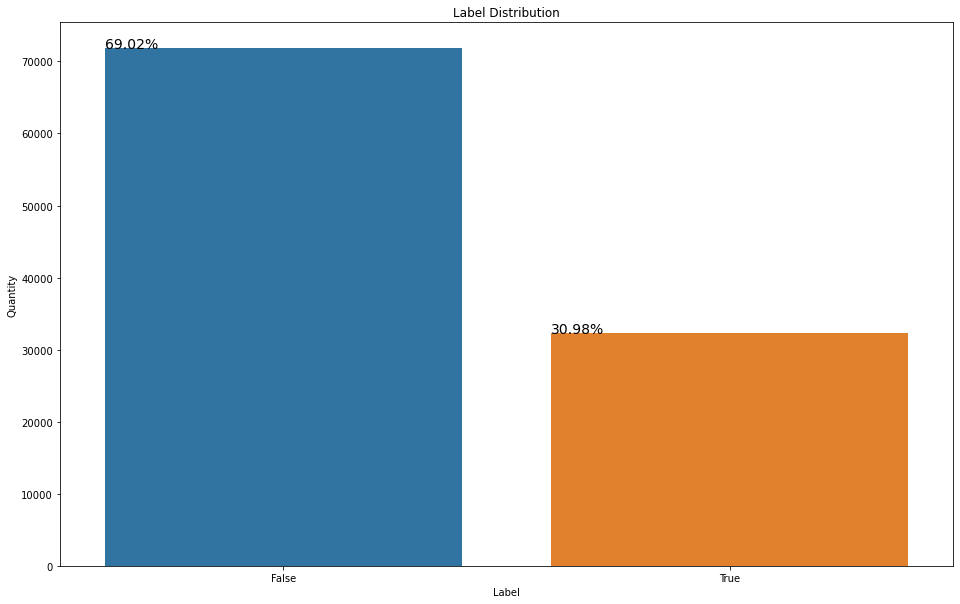

In [44]:
plt.figure(figsize=[16,10])
labels_occ = df_temporal['label']
ax = sns.barplot(x=labels_occ.value_counts().index, y=labels_occ.value_counts(), orient='v')
for p in ax.patches:
    (ax.annotate('{:.2f}%'.format(p.get_height()/len(labels_occ)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()

Creating a new dataframe with columns dividing the sets and building the models.

In [45]:
df_model = df_temporal[['events_accum', 'events_qty', 'offers_accum', 'offers_qty', 'case:concept:name', 'label']].copy()

Separating a set with 20% of the data for validation.

In [178]:
x_train_test, x_validation = train_test_split(df_model['case:concept:name'].drop_duplicates(), test_size=0.2)
x_train_test = df_model.merge(x_train_test, on="case:concept:name")
x_validation = df_model.merge(x_validation, on="case:concept:name")

In [179]:
y_validation = x_validation['label']
x_validation = x_validation.iloc[:,0:4]

I used the *sklearn* library's *train_test_split* function to separate the data for training and testing. We will use 25% of the data for testing. Recalling that 20% of the total has already been withdrawn for the validation set.

**Note: Training set applications do not appear in the test set and vice versa.**

In [180]:
x_train, x_test = train_test_split(x_train_test['case:concept:name'].drop_duplicates(), test_size=0.25)
x_train = x_train_test.merge(x_train, on="case:concept:name")
x_test = x_train_test.merge(x_test, on="case:concept:name")

y_test = x_test['label']
y_train = x_train['label']
x_train = x_train.iloc[:,0:4]
x_test = x_test.iloc[:,0:4]

## **Building a Model**

To find the model, we used Sklearn's pipeline and GridSearch to find the best classifier and parameters.

The classifiers used were:

* LogisticRegression
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier

In [181]:
pipe = Pipeline([
   ('scaler', StandardScaler()),
   ('classifier', LogisticRegression())
])

List with some parameters chosen for each classifier. Where the best parameters will be chosen and the best classifier.

In [182]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
     'classifier__C' : np.logspace(-4, 4, 20)},
    {'classifier' : [KNeighborsClassifier()],
     'classifier__leaf_size' : [1,5,10,30],
     'classifier__n_neighbors' : [2,5,10,20], 
     'classifier__p' : [1,2]},
    {'classifier' : [DecisionTreeClassifier(random_state=199)],
     'classifier__max_depth' : [10, 50, 100],
     'classifier__min_samples_split' : [1, 5, 10]},
    {'classifier' : [RandomForestClassifier(random_state=199)],
     'classifier__n_estimators' : [10,50,250],
     'classifier__max_depth' : [10, 50, 100],
     'classifier__min_samples_split' : [1, 5, 10]}
]

Creating classifier using GridSearchCV and estimator and parameters that were previously defined.

In [187]:
clf_gs = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1)

Performing the training using the *fit* function.

In [188]:
clf_gs.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+0...
                         {'classifier': [DecisionTreeClassifier(random_state=199)],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__min_samples_split': [1, 5, 10]},
                         {'classifier': [RandomForestClassifier(max_depth=50,
                                                                min_samples_split=10,
                                                                n_estimators=250,
                                                       

Printing the best parameters and the best score.

In [189]:
print("Best params (CV score=%0.5f):" % clf_gs.best_score_)
print(clf_gs.best_params_)

Best params (CV score=0.86760):
{'classifier': RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=250,
                       random_state=199), 'classifier__max_depth': 50, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 250}


Performing the prediction with the best classifier found.

In [190]:
y_pred = clf_gs.predict(x_test)

## **Evaluating the Model**

Since we already have a trained model and perform a prediction, we can evaluate the model using several metrics:

* **Accuracy**: It is the number of data correctly predicted in all data sets. It tells you how accurate the model is.
* **Recall**: It is the proportion of positive observations correctly predicted in relation to the total of predicted observations.
* **Precision**: It is the proportion of positive observations correctly predicted in relation to the total of positive predicted observations. It's how accurate the model is.

In [191]:
accuracy_inb = metrics.accuracy_score(y_test, y_pred)
recall_inb = metrics.recall_score(y_test, y_pred)
precision_inb = metrics.precision_score(y_test, y_pred)
f1_inb = metrics.f1_score(y_test, y_pred)

print("Accuracy: ", accuracy_inb)
print("Recall: ", recall_inb)
print("Precision: ", recall_inb)
print("F1-Score: ", f1_inb)

Accuracy:  0.8763725679059912
Recall:  0.8218667494952633
Precision:  0.8218667494952633
F1-Score:  0.804805718196335


For a better visualization of the prediction results of each class, we can create a confusion matrix. Confusion matrix is precisely a table that shows the frequency of classification for each class of the model.

In the confusion matrix:

* First quadrant is the *true positive* (TP): it occurs when in the real set, the class that is to be predicted was correctly predicted.
* Second quadrant is the *false positive* (FP): it occurs when in the real set, the class to be predicted was predicted incorrectly.
* Third quadrant is the *false negative* (FN): it occurs when in the real set, the class that is not intended to be predicted was incorrectly predicted.
* Fourth quadrant is the *true negative* (TN): it occurs when in the real set, the class that is not wanted to be predicted that was correctly predicted.

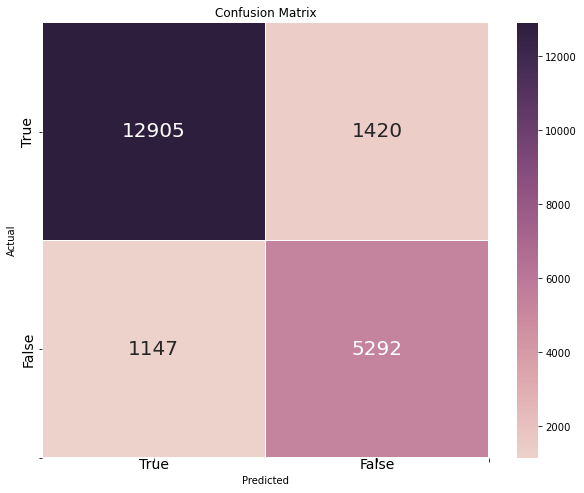

In [192]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

Performing the prediction with the separate data for validation.

In [193]:
y_pred_val = clf_gs.predict(x_validation)

In [194]:
accuracy_inb_val = metrics.accuracy_score(y_validation, y_pred_val)
recall_inb_val = metrics.recall_score(y_validation, y_pred_val)
precision_inb_val = metrics.precision_score(y_validation, y_pred_val)
f1_inb_val = metrics.f1_score(y_validation, y_pred_val)

print("Accuracy: ", accuracy_inb_val)
print("Recall: ", recall_inb_val)
print("Precision: ", recall_inb_val)
print("F1-Score: ", f1_inb_val)

Accuracy:  0.8748621036980191
Recall:  0.820306454109271
Precision:  0.820306454109271
F1-Score:  0.8024831554243319


Building the confusion matrix.

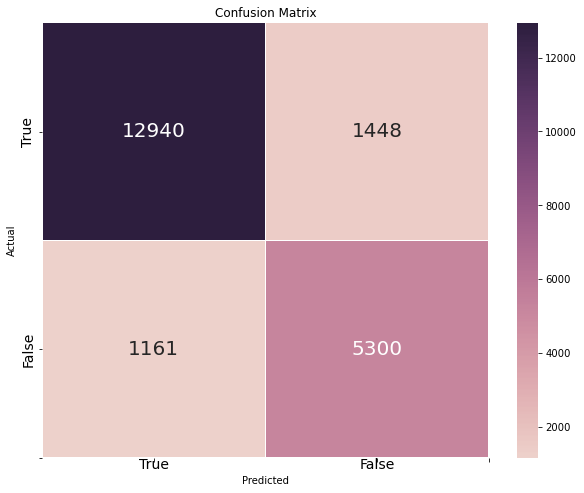

In [195]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_validation, y_pred_val), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

## **Checking feature importances**

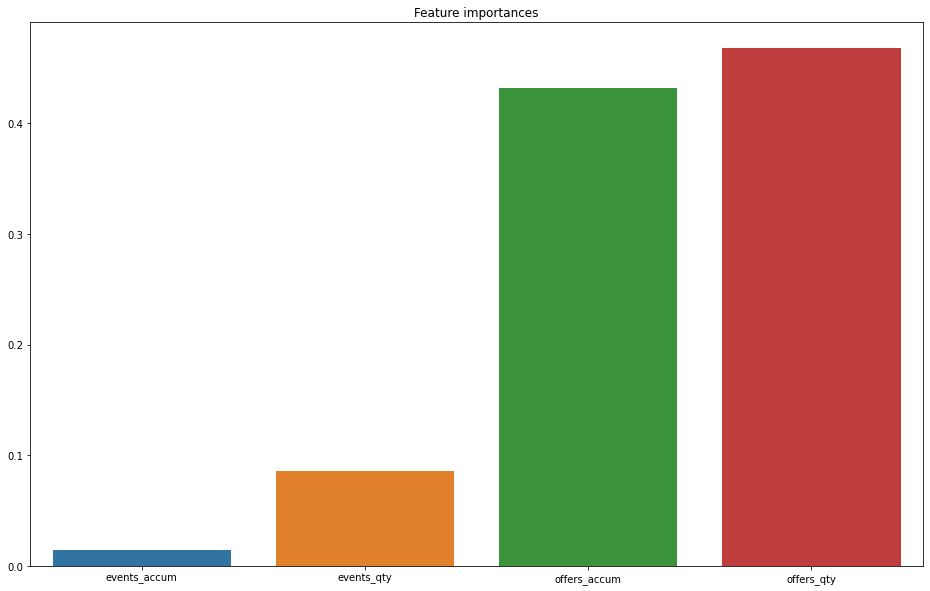

In [196]:
features = x_train.columns

features_importances = pd.Series(clf_gs.best_estimator_.named_steps["classifier"].feature_importances_, index=features)

plt.figure(figsize=[16,10])
ax = sns.barplot(x=features_importances.values, y=features_importances)
ax.set_title("Feature importances")
plt.xticks(list(range(len(features_importances))), features)
plt.show()

## **Dealing with data imbalance**

When distributing the variable Label (our dependent variable) we notice that the classes are unbalanced, where the minority class is a class that is interested in finding out.

When classes are unbalanced, the model can become biased, tending towards the majority class. For this, we will apply some techniques to balance the data.

Selected techniques:

1. Sampling (Random Under Sampling)
2. Sampling (Random Over Sampling)
3. Cost-Sensitive Learning
4. Sampling (Tomek Link)
5. Sampling (SMOTE)

Dividing the data into the variables x and y. Note that y is contained in the set x, it will be used in x, but then it will be disregarded.


In [197]:
y = x_train_test.label
x = x_train_test

### **Technique 1: Sampling (Random under sampling)** 

We applied **Random Under Sampler** - Simple subsampling technique. A sample of the majority class is taken to balance it with the minority class.


In [198]:
rus = RandomUnderSampler(random_state=0)
x_rus, y_rus = rus.fit_sample(x, y)

We visualized the distribution of the 'label' variable and realized that the classes are now equally balanced.

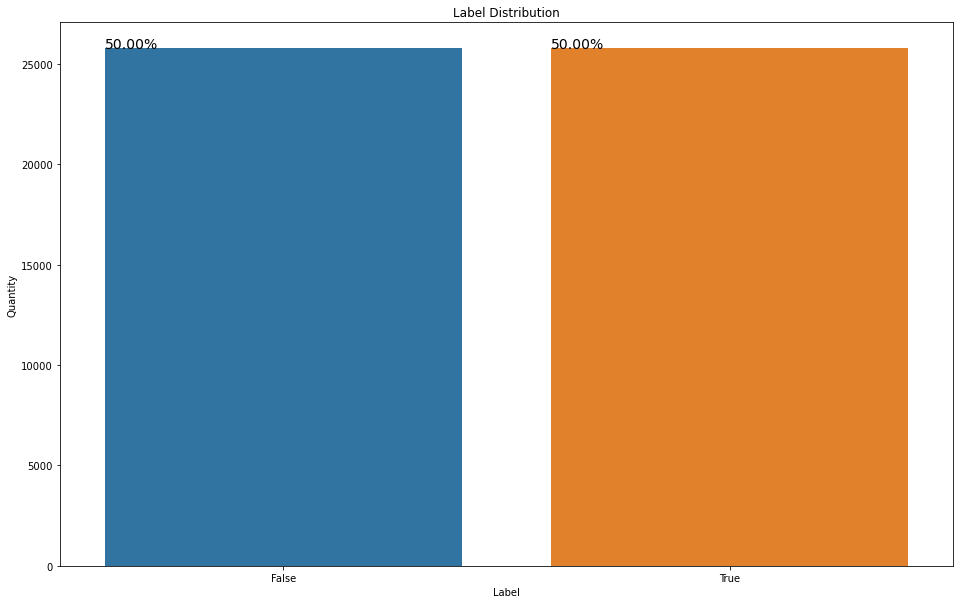

In [199]:
y_rus_index, y_rus_counts = np.unique(y_rus, return_counts=True)
plt.figure(figsize=[16,10])
ax = sns.barplot(x=y_rus_index, y=y_rus_counts, orient='v')
for p in ax.patches:
    (ax.annotate('{:.2f}%'.format(p.get_height()/len(y_rus)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()

Converting the data array to a dataframe.

In [200]:
x_rus_df = (pd.DataFrame(x_rus, columns=df_model.columns))
x_rus_df.head()

,events_accum,events_qty,offers_accum,offers_qty,case:concept:name,label
0,37,31,0,0,Application_1607375745,False
1,10,0,0,0,Application_867002961,False
2,19,17,0,0,Application_1467009170,False
3,15,0,1,0,Application_1425378083,False
4,21,19,0,0,Application_846363201,False


Dividing the data into train and test sets,applying *train_test_split* function.

In [201]:
x_train_rus, x_test_rus = train_test_split(x_rus_df['case:concept:name'].drop_duplicates(), test_size=0.25)
x_train_rus = x_rus_df.merge(x_train_rus, on="case:concept:name")
x_test_rus = x_rus_df.merge(x_test_rus, on="case:concept:name")

y_test_rus = x_test_rus['label'].astype(bool)
y_train_rus = x_train_rus['label'].astype(bool)
x_train_rus = x_train_rus.iloc[:,0:4]
x_test_rus = x_test_rus.iloc[:,0:4]

Performing the training using the *fit* function.

In [202]:
clf_gs.fit(x_train_rus, y_train_rus)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+0...
                         {'classifier': [DecisionTreeClassifier(random_state=199)],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__min_samples_split': [1, 5, 10]},
                         {'classifier': [RandomForestClassifier(max_depth=50,
                                                                min_samples_split=10,
                                                                n_estimators=50,
                                                        

Printing the best parameters and the best score.

In [203]:
print("Best params (CV score=%0.5f):" % clf_gs.best_score_)
print(clf_gs.best_params_)

Best params (CV score=0.88156):
{'classifier': RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=50,
                       random_state=199), 'classifier__max_depth': 50, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}


Performing the prediction with the best classifier found.

In [204]:
y_pred_rus = clf_gs.predict(x_test_rus)

### **Evaluating the model (Technique 1)** 

Evaluating with the new test data set (split after balancing)

In [205]:
accuracy_rus = metrics.accuracy_score(y_test_rus, y_pred_rus)
recall_rus = metrics.recall_score(y_test_rus, y_pred_rus)
precision_rus = metrics.precision_score(y_test_rus, y_pred_rus)
f1_rus = metrics.f1_score(y_test_rus, y_pred_rus)

print("Accuracy: ", accuracy_rus)
print("Recall: ", recall_rus)
print("Precision: ", precision_rus)
print("f1-Score: ", f1_rus)

Accuracy:  0.8810970858656693
Recall:  0.9158530915853091
Precision:  0.8573915566516757
f1-Score:  0.8856586243069084


Building the confusion matrix.

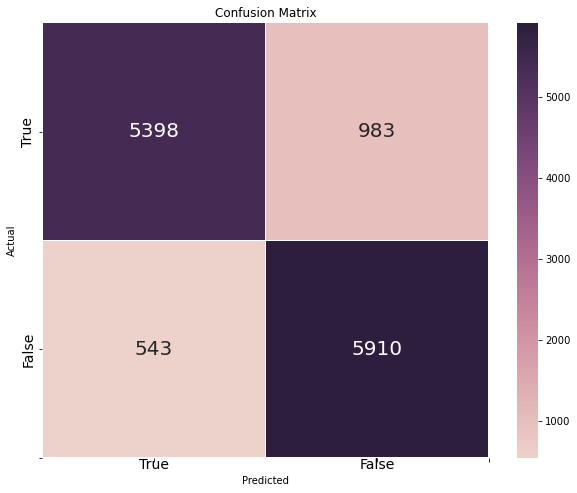

In [206]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test_rus, y_pred_rus), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

Performing the prediction and evaluating with the separate data for validation.

In [207]:
y_pred_rus_val = clf_gs.predict(x_validation)

In [209]:
accuracy_rus_val = metrics.accuracy_score(y_validation, y_pred_rus_val)
recall_rus_val = metrics.recall_score(y_validation, y_pred_rus_val)
precision_rus_val = metrics.precision_score(y_validation, y_pred_rus_val)
f1_rus_val = metrics.f1_score(y_validation, y_pred_rus_val)

print("Accuracy: ", accuracy_rus_val)
print("Recall: ", recall_rus_val)
print("Precision: ", precision_rus_val)
print("F1-Score: ", f1_rus_val)

Accuracy:  0.8697299630677731
Recall:  0.920445751431667
Precision:  0.7297827954350227
F1-Score:  0.8140999315537304


Building the confusion matrix.

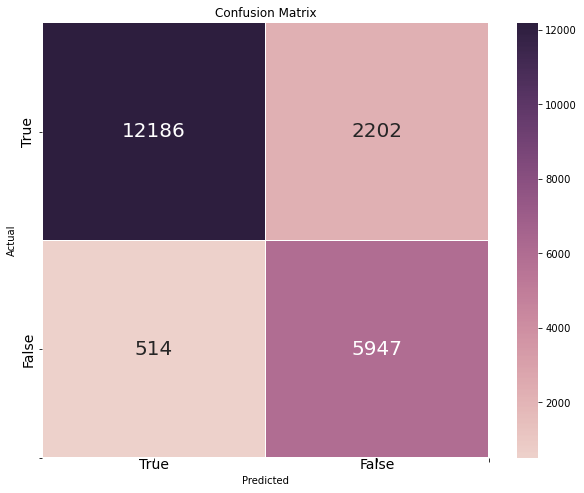

In [210]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_validation, y_pred_rus_val), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

### **Technique 2: Sampling (Random over sampling)** 

We applied **Random Over Sampler** - technique simply replicates minority class examples at random.

In [211]:
ros = RandomOverSampler(random_state=0)
x_ros, y_ros = ros.fit_sample(x, y)

We visualized the distribution of the 'label' variable and realized that the classes are now equally balanced.

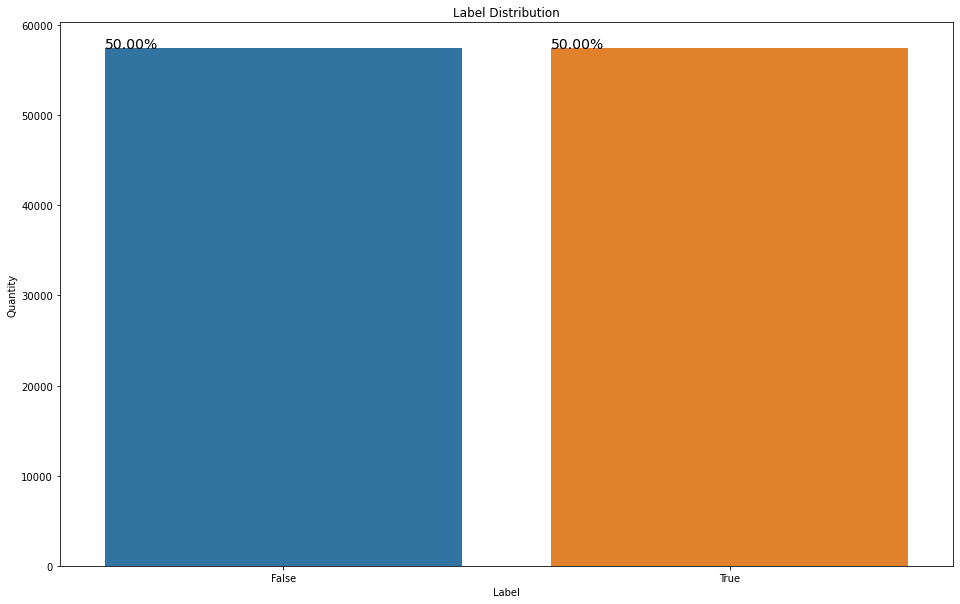

In [212]:
y_ros_index, y_ros_counts = np.unique(y_ros, return_counts=True)
plt.figure(figsize=[16,10])
ax = sns.barplot(x=y_ros_index, y=y_ros_counts, orient='v')
for p in ax.patches:
    (ax.annotate('{:.2f}%'.format(p.get_height()/len(y_ros)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()

Converting the data array to a dataframe.

In [213]:
x_ros_df = pd.DataFrame(x_ros, columns=df_model.columns)
x_ros_df.head()

,events_accum,events_qty,offers_accum,offers_qty,case:concept:name,label
0,17,0,1,0,Application_652823628,False
1,19,17,0,0,Application_652823628,False
2,40,19,0,0,Application_652823628,True
3,18,0,1,0,Application_1691306052,False
4,31,18,0,0,Application_1691306052,True


Dividing the data into train and test sets,applying *train_test_split* function.

In [214]:
x_train_ros, x_test_ros = train_test_split(x_ros_df['case:concept:name'].drop_duplicates(), test_size=0.25)
x_train_ros = x_ros_df.merge(x_train_ros, on="case:concept:name")
x_test_ros = x_ros_df.merge(x_test_ros, on="case:concept:name")

y_test_ros = x_test_ros['label'].astype(bool)
y_train_ros = x_train_ros['label'].astype(bool)
x_train_ros = x_train_ros.iloc[:,0:4]
x_test_ros = x_test_ros.iloc[:,0:4]

Performing the training using the *fit* function.

In [216]:
clf_gs.fit(x_train_ros, y_train_ros)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+0...
                         {'classifier': [DecisionTreeClassifier(random_state=199)],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__min_samples_split': [1, 5, 10]},
                         {'classifier': [RandomForestClassifier(max_depth=50,
                                                                min_samples_split=10,
                                                                n_estimators=50,
                                                        

Printing the best parameters and the best score.

In [217]:
print("Best params (CV score=%0.5f):" % clf_gs.best_score_)
print(clf_gs.best_params_)

Best params (CV score=0.87794):
{'classifier': KNeighborsClassifier(n_neighbors=20, p=1), 'classifier__leaf_size': 30, 'classifier__n_neighbors': 20, 'classifier__p': 1}


Performing the prediction with the best classifier found.

In [218]:
y_pred_ros = clf_gs.predict(x_test_ros)

### **Evaluating the model (Tecnique 2)** 

**Evaluating with the new test data set (split after balancing).**

In [219]:
accuracy_ros = metrics.accuracy_score(y_test_ros, y_pred_ros)
recall_ros = metrics.recall_score(y_test_ros, y_pred_ros)
precision_ros = metrics.precision_score(y_test_ros, y_pred_ros)
f1_ros = metrics.f1_score(y_test_ros, y_pred_ros)

print("Accuracy: ", accuracy_ros)
print("Recall: ", recall_ros)
print("Precision: ", precision_ros)
print("F1-Score: ", f1_ros)

Accuracy:  0.8814305172353578
Recall:  0.9224980659680709
Precision:  0.8512005191434133
F1-Score:  0.8854163150966958


Building the confusion matrix.

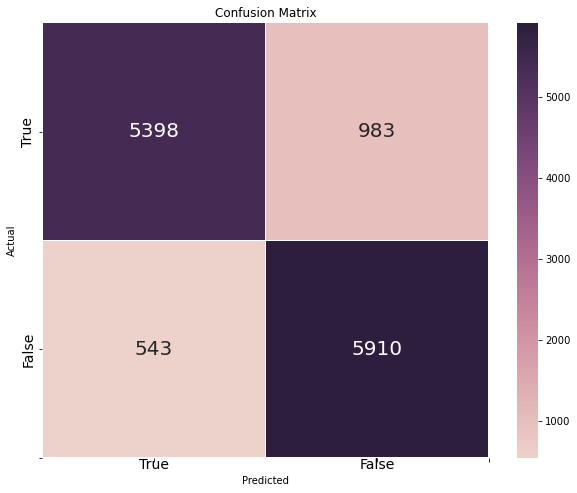

In [220]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test_rus, y_pred_rus), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

Performing the prediction and evaluating with the separate data for validation.

In [221]:
y_pred_ros_val = clf_gs.predict(x_validation)

In [222]:
accuracy_ros_val = metrics.accuracy_score(y_validation, y_pred_ros_val)
recall_ros_val = metrics.recall_score(y_validation, y_pred_ros_val)
precision_ros_val = metrics.precision_score(y_validation, y_pred_ros_val)
f1_ros_val = metrics.f1_score(y_validation, y_pred_ros_val)

print("Accuracy: ", accuracy_ros_val)
print("Recall: ", recall_ros_val)
print("Precision: ", precision_ros_val)
print("F1-Score: ", f1_ros_val)

Accuracy:  0.8646457863686507
Recall:  0.9218387246556261
Precision:  0.7199323099238487
F1-Score:  0.8084702049681012


Building the confusion matrix.

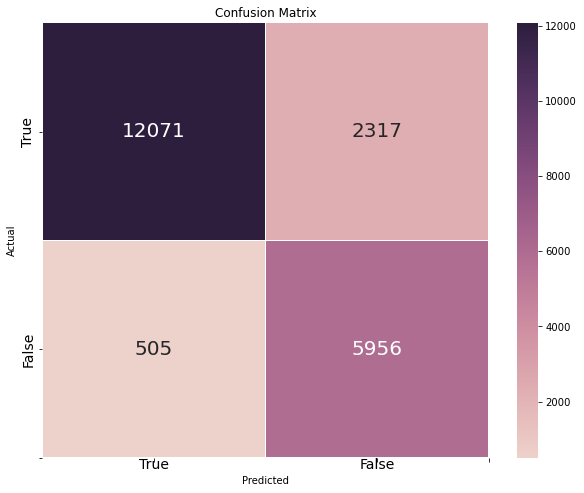

In [223]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_validation, y_pred_ros_val), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

### **Technique 3: Cost-Sensitive Learning** 

We apply the **Cost Sensitive Learning** to consider the costs of misclassification and to minimize them.

In [224]:
param_grid_cost = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__class_weight': ['balanced']},
    {'classifier' : [KNeighborsClassifier()],
     'classifier__leaf_size' : [1,5,10,30],
     'classifier__n_neighbors' : [2,5,10,20], 
     'classifier__p' : [1,2],
     'classifier__weights': ['distance']},
    {'classifier' : [DecisionTreeClassifier(random_state=199)],
     'classifier__max_depth' : [10, 50, 100],
     'classifier__min_samples_split' : [1, 5, 10],
     'classifier__class_weight': ['balanced']},
    {'classifier' : [RandomForestClassifier(random_state=199)],
     'classifier__n_estimators' : [10,50,250],
     'classifier__max_depth' : [10, 50, 100],
     'classifier__min_samples_split' : [1, 5, 10],
     'classifier__class_weight': ['balanced', 'balanced_subsample']}
]

Creating classifier using GridSearchCV and estimator and parameters (with weights) that were previously defined.

In [225]:
clf_gs_cost = GridSearchCV(estimator=pipe, param_grid=param_grid_cost, n_jobs=-1)

Performing the training using the *fit* function.

In [227]:
clf_gs_cost.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+0...
                          'classifier__min_samples_split': [1, 5, 10]},
                         {'classifier': [RandomForestClassifier(class_weight='balanced_subsample',
                                                                max_depth=50,
                                                                min_samples_split=10,
                                                                n_estimators=50,
                                                                random_state=199)],
                       

Printing the best parameters and the best score.

In [228]:
print("Best params (CV score=%0.5f):" % clf_gs_cost.best_score_)
print(clf_gs_cost.best_params_)

Best params (CV score=0.86656):
{'classifier': RandomForestClassifier(class_weight='balanced_subsample', max_depth=50,
                       min_samples_split=10, n_estimators=50, random_state=199), 'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 50, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}


Performing the prediction with the best classifier found.

In [229]:
y_pred_cs = clf_gs_cost.predict(x_test)

### **Evaluating the model (Tecnique 3)** 

In [230]:
accuracy_cs = metrics.accuracy_score(y_test, y_pred_cs)
recall_cs = metrics.recall_score(y_test, y_pred_cs)
precision_cs = metrics.precision_score(y_test, y_pred_cs)
f1_cs = metrics.f1_score(y_test, y_pred_cs)

print("Accuracy: ", accuracy_cs)
print("Recall: ", recall_cs)
print("Precision: ", precision_cs)
print("F1-Score: ", f1_cs)

Accuracy:  0.8732421498747833
Recall:  0.9142724025469794
Precision:  0.7389230576126522
F1-Score:  0.8172983479105929


Building the confusion matrix

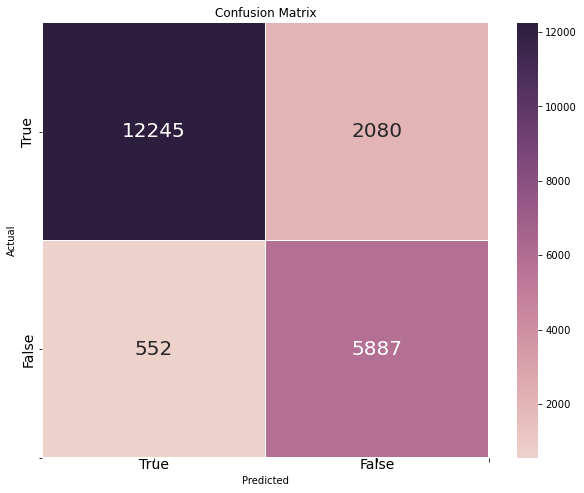

In [231]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred_cs), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

Performing the prediction and evaluating with the separate data for validation.

In [232]:
y_pred_cs_val = clf_gs_cost.predict(x_validation)

In [233]:
accuracy_cs_val = metrics.accuracy_score(y_validation, y_pred_cs_val)
recall_cs_val = metrics.recall_score(y_validation, y_pred_cs_val)
precision_cs_val = metrics.precision_score(y_validation, y_pred_cs_val)
f1_cs_val = metrics.f1_score(y_validation, y_pred_cs_val)

print("Accuracy: ", accuracy_cs_val)
print("Recall: ", recall_cs_val)
print("Precision: ", precision_cs_val)
print("F1-Score: ", f1_cs_val)

Accuracy:  0.8720322317617152
Recall:  0.9136356601145333
Precision:  0.7366778984150755
F1-Score:  0.8156694763023351


Building the confusion matrix.

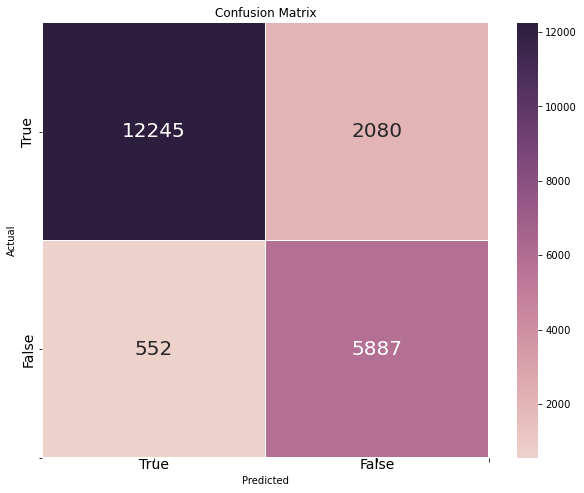

In [234]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test, y_pred_cs), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

For techniques 4 and 5 we apply a transformation to the 'case: concept: name' column of set X, so that the value would be numeric.

In [235]:
x_new = x.copy()
y_new = x_new.label

In [236]:
x_new['case:concept:name'] = x_new['case:concept:name'].str.slice(start=12)
x_new.head()

,events_accum,events_qty,offers_accum,offers_qty,case:concept:name,label
0,17,0,1,0,652823628,False
1,19,17,0,0,652823628,False
2,40,19,0,0,652823628,True
3,18,0,1,0,1691306052,False
4,31,18,0,0,1691306052,True


### **Technique 4: Sampling (Under sampling - TomekLink)**

We applied **TomekLink** to balance the data. Tomeks links can be considered noise or instances that are close to an edge. They remove unwanted overlap between classes, where the links of the major classes are removed until all closest neighboring pairs with minimum distance are in the same class.

In [237]:
tkl = TomekLinks()
x_tkl, y_tkl = tkl.fit_sample(x_new, y_new)

We visualized the distribution of the 'label' variable and realized that the classes are now better balanced.

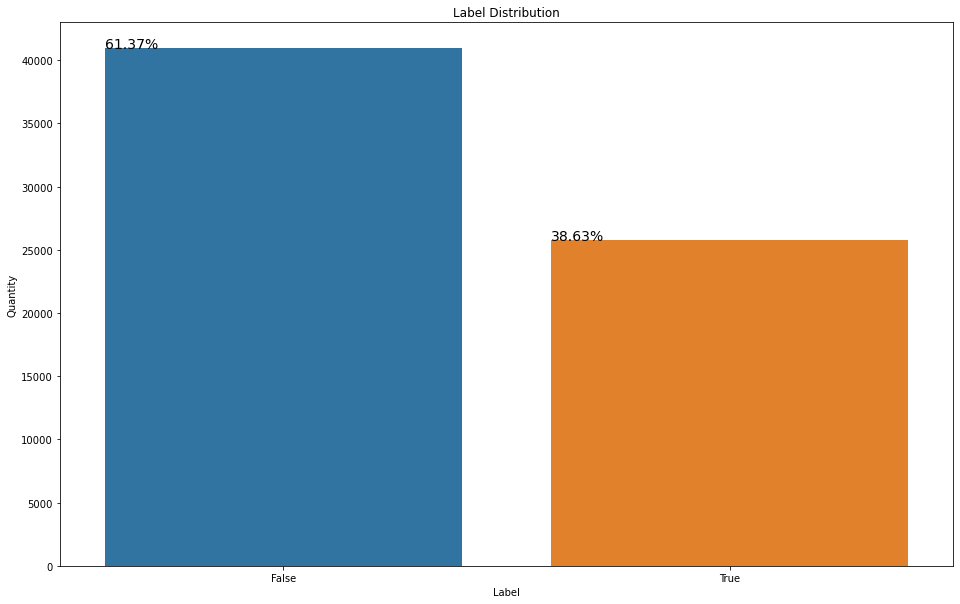

In [238]:
y_tkl_index, y_tkl_counts = np.unique(y_tkl, return_counts=True)
plt.figure(figsize=[16,10])
ax = sns.barplot(x=y_tkl_index, y=y_tkl_counts, orient='v')
for p in ax.patches:
    (ax.annotate('{:.2f}%'.format(p.get_height()/len(y_tkl)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()

Converting the data array to a dataframe.


In [239]:
x_tkl_df = pd.DataFrame(x_tkl, columns=df_model.columns)
x_tkl_df.head()

,events_accum,events_qty,offers_accum,offers_qty,case:concept:name,label
0,17,0,1,0,6.52824e+08,False
1,19,17,0,0,6.52824e+08,False
2,40,19,0,0,6.52824e+08,True
3,31,18,0,0,1.69131e+09,True
4,11,0,0,0,1.74679e+09,False


Dividing the data into train and test sets,applying *train_test_split* function.

In [240]:
x_train_tkl, x_test_tkl = train_test_split(x_tkl_df['case:concept:name'].drop_duplicates(), test_size=0.25)
x_train_tkl = x_tkl_df.merge(x_train_tkl, on="case:concept:name")
x_test_tkl = x_tkl_df.merge(x_test_tkl, on="case:concept:name")

y_test_tkl = x_test_tkl['label'].astype(bool)
y_train_tkl = x_train_tkl['label'].astype(bool)
x_train_tkl = x_train_tkl.iloc[:,0:4]
x_test_tkl = x_test_tkl.iloc[:,0:4]

Performing the training using the *fit* function.

In [242]:
clf_gs.fit(x_train_tkl, y_train_tkl)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+0...
                         {'classifier': [DecisionTreeClassifier(random_state=199)],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__min_samples_split': [1, 5, 10]},
                         {'classifier': [RandomForestClassifier(max_depth=50,
                                                                min_samples_split=10,
                                                                n_estimators=250,
                                                       

Printing the best parameters and the best score.

In [243]:
print("Best params (CV score=%0.5f):" % clf_gs.best_score_)
print(clf_gs.best_params_)

Best params (CV score=0.88280):
{'classifier': RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=250,
                       random_state=199), 'classifier__max_depth': 50, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 250}


Performing the prediction with the best classifier found.

In [245]:
y_pred_tkl = clf_gs.predict(x_test_tkl)

### **Evaluating the model (Tecnique 4)** 

Evaluating with the new test data set (split after balancing).

In [246]:
accuracy_tkl = metrics.accuracy_score(y_test_tkl, y_pred_tkl)
recall_tkl = metrics.recall_score(y_test_tkl, y_pred_tkl)
precision_tkl = metrics.precision_score(y_test_tkl, y_pred_tkl)
f1_tkl = metrics.f1_score(y_test_tkl, y_pred_tkl)

print("Accuracy: ", accuracy_tkl)
print("Recall: ", recall_tkl)
print("Precision: ", precision_tkl)
print("F1-Score: ", f1_tkl)

Accuracy:  0.8856201318154584
Recall:  0.8897832817337461
Precision:  0.827645788336933
F1-Score:  0.8575904513241327


Building the confusion matrix

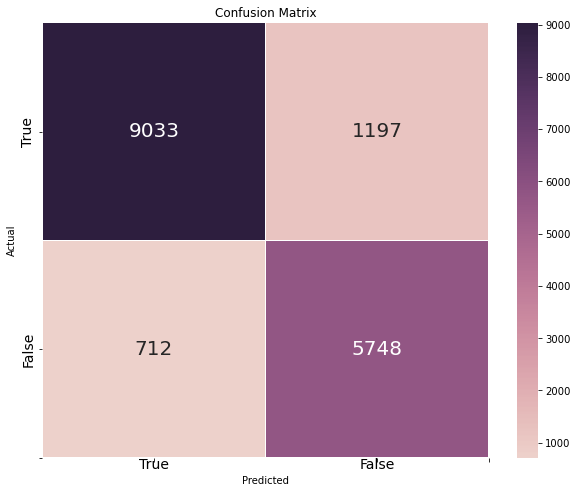

In [247]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test_tkl, y_pred_tkl), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

Performing the prediction and evaluating with the separate data for validation.

In [248]:
y_pred_tkl_val = clf_gs.predict(x_validation)

In [249]:
accuracy_tkl_val = metrics.accuracy_score(y_validation, y_pred_tkl_val)
recall_tkl_val = metrics.recall_score(y_validation, y_pred_tkl_val)
precision_tkl_val = metrics.precision_score(y_validation, y_pred_tkl_val)
f1_tkl_val = metrics.f1_score(y_validation, y_pred_tkl_val)

print("Accuracy: ", accuracy_tkl_val)
print("Recall: ", recall_tkl_val)
print("Precision: ", precision_tkl_val)
print("F1-Score: ", f1_tkl_val)

Accuracy:  0.8722240874862104
Recall:  0.8877882680699583
Precision:  0.7473615635179153
F1-Score:  0.8115449915110357


Building the confusion matrix.

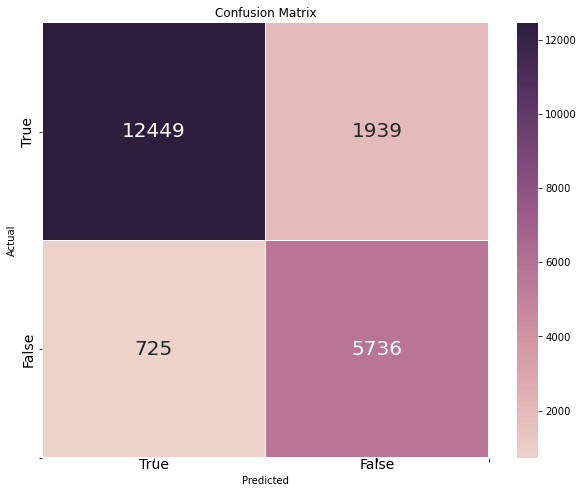

In [250]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_validation, y_pred_tkl_val), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

### **Technique 5: Sampling (Over sampling - SMOTE)**

We applied **SMOTE** to balance the data. The Synthetic Minority Over-sampling Technique (SMOTE) generates synthetic data based on the similarities of resource space between existing minority entities. We search for the k neighbors closest to each instance of the minority class, randomly choose one and from it generate a new instance.

In [253]:
smt = SMOTE(random_state=0)
x_smt, y_smt = smt.fit_sample(x_new, y_new)

We visualized the distribution of the 'label' variable and realized that the classes are now better balanced.

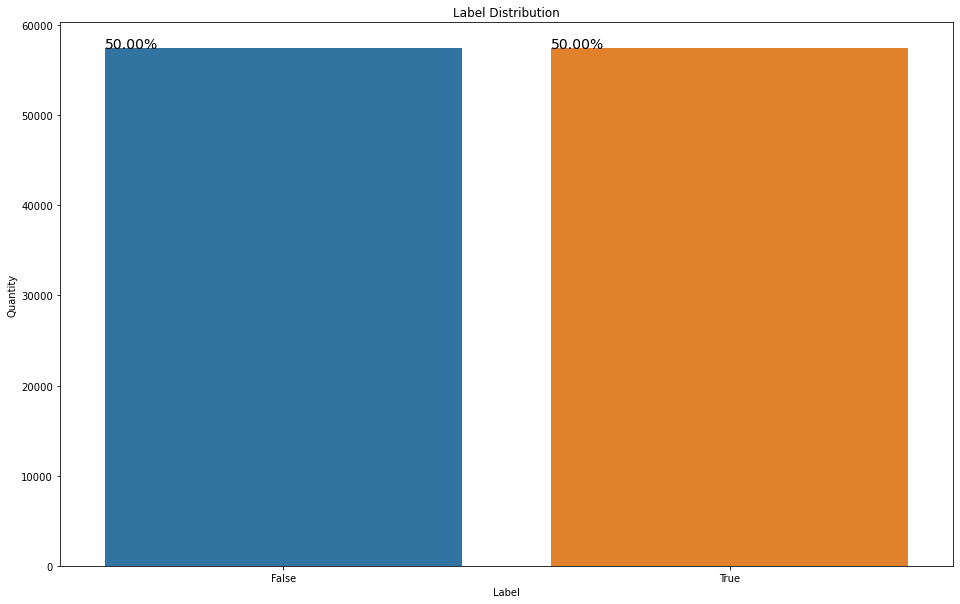

In [254]:
y_smt_index, y_smt_counts = np.unique(y_smt, return_counts=True)
plt.figure(figsize=[16,10])
ax = sns.barplot(x=y_smt_index, y=y_smt_counts, orient='v')
for p in ax.patches:
    (ax.annotate('{:.2f}%'.format(p.get_height()/len(y_smt)*100), 
                 (p.get_x(), p.get_height()+1), fontsize=14))
ax.set(xlabel="Label", ylabel = "Quantity")
ax.set_title("Label Distribution")
plt.show()

Converting the data array to a dataframe.

In [255]:
x_smt_df = pd.DataFrame(x_smt, columns=df_model.columns)
x_smt_df.head()

,events_accum,events_qty,offers_accum,offers_qty,case:concept:name,label
0,17,0,1,0,6.52824e+08,False
1,19,17,0,0,6.52824e+08,False
2,40,19,0,0,6.52824e+08,True
3,18,0,1,0,1.69131e+09,False
4,31,18,0,0,1.69131e+09,True


Dividing the data into train and test sets,applying *train_test_split* function.

In [256]:
x_train_smt, x_test_smt = train_test_split(x_smt_df['case:concept:name'].drop_duplicates(), test_size=0.25)
x_train_smt = x_smt_df.merge(x_train_smt, on="case:concept:name")
x_test_smt = x_smt_df.merge(x_test_smt, on="case:concept:name")

y_test_smt = x_test_smt['label'].astype(bool)
y_train_smt = x_train_smt['label'].astype(bool)
x_train_smt = x_train_smt.iloc[:,0:4]
x_test_smt = x_test_smt.iloc[:,0:4]

Performing the training using the *fit* function.

In [257]:
clf_gs.fit(x_train_smt, y_train_smt)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+0...
                         {'classifier': [DecisionTreeClassifier(random_state=199)],
                          'classifier__max_depth': [10, 50, 100],
                          'classifier__min_samples_split': [1, 5, 10]},
                         {'classifier': [RandomForestClassifier(max_depth=50,
                                                                min_samples_split=10,
                                                                n_estimators=250,
                                                       

Printing the best parameters and the best score.

In [258]:
print("Best params (CV score=%0.5f):" % clf_gs.best_score_)
print(clf_gs.best_params_)

Best params (CV score=0.87608):
{'classifier': RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=250,
                       random_state=199), 'classifier__max_depth': 50, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 250}


Performing the prediction with the best classifier found.

In [259]:
y_pred_smt = clf_gs.predict(x_test_smt)

### **Evaluating the model (Tecnique 5)** 

In [260]:
accuracy_smt = metrics.accuracy_score(y_test_smt, y_pred_smt)
recall_smt = metrics.recall_score(y_test_smt, y_pred_smt)
precision_smt = metrics.precision_score(y_test_smt, y_pred_smt)
f1_smt = metrics.f1_score(y_test_tkl, y_pred_tkl)

print("Accuracy: ", accuracy_smt)
print("Recall: ", recall_smt)
print("Precision: ", precision_smt)
print("F1-Score: ", f1_smt)

Accuracy:  0.8835942109464477
Recall:  0.9402922755741128
Precision:  0.8440779610194903
F1-Score:  0.8575904513241327


Building the confusion matrix.

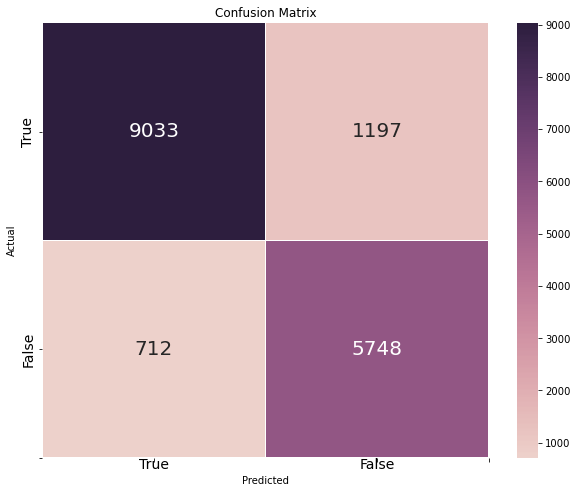

In [261]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_test_tkl, y_pred_tkl), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

Performing the prediction and evaluating with the separate data for validation.

In [262]:
y_pred_smt_val = clf_gs.predict(x_validation)

In [263]:
accuracy_smt_val = metrics.accuracy_score(y_validation, y_pred_smt_val)
recall_smt_val = metrics.recall_score(y_validation, y_pred_smt_val)
precision_smt_val = metrics.precision_score(y_validation, y_pred_smt_val)
f1_smt_val = metrics.f1_score(y_validation, y_pred_smt_val)

print("Accuracy: ", accuracy_smt_val)
print("Recall: ", recall_smt_val)
print("Precision: ", precision_smt_val)
print("F1-Score: ", f1_smt_val)

Accuracy:  0.8610005276032424
Recall:  0.9411855749883918
Precision:  0.7071752529363879
F1-Score:  0.8075697211155379


Building the confusion matrix.

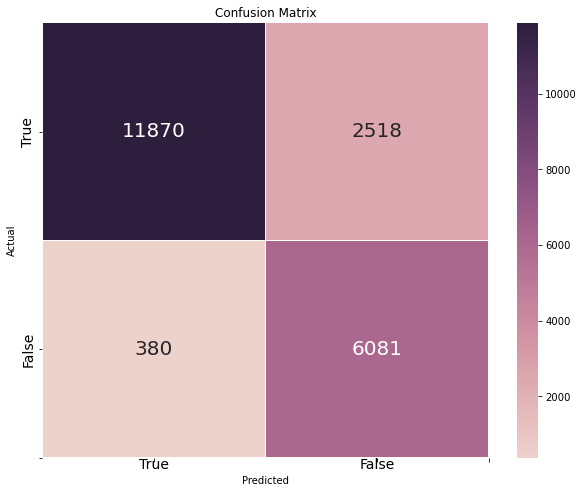

In [264]:
plt.figure(figsize=(10,8))
ax = (sns.heatmap(metrics.confusion_matrix(y_validation, y_pred_smt_val), annot=True, annot_kws={"size": 20}, 
                 linewidths=.1, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True)))
plt.yticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
plt.xticks([0.5,1.5,2], ['True', 'False'], va='center', fontsize=14)
ax.set_title("Confusion Matrix")
ax.set(xlabel="Predicted", ylabel="Actual");
plt.show()

### **Results** 

Let's compare the results of each technique used to find out which would be the best option for balancing the data.

For the results table were used:

* Unbalanced data {training and test}
* Unbalanced data {test with validation set

* Balanced data using Random Under Sampling (RUS) {training and test}
* Balanced data using Random Under Sampling (RUS) {test with validation set}

* Balanced data using Random Over Sampling (ROS) {training and test}
* Balanced data using Random Over Sampling (ROS) {test with validation set}

* Balanced data using Tomek Link {training and test}
* Balanced data using Tomek Link {test with validation set}

* Balanced data using SMOTE {training and test}
* Balanced data using SMOTE {test with validation set}

* Unbalanced data using Cost Sensitive Learning {training and test}
* Unbalanced data using Tomek Link {test with validation set}

In [266]:
results = (pd.DataFrame({
    "Technique": ["Unbalanced (train and test)", "Unbalanced (train and val)",  "RUS (train and test)",  
                  "RUS (train)\ Unbalanced data (val)", "ROS (train and test)", "ROS (train)\ Unbalanced data (val)", 
                  "TomekLink (train and test)",  "TomekLink (train)\ Unbalanced data (val)",
                  "SMOTE (train and test)", "SMOTE (train)\ Unbalanced data (test)", "Cost Sensitive (train and test)", 
                  "Cost-Sensitive (train)\ Unbalanced data (val)"],
    "Accuracy": [accuracy_inb, accuracy_inb_val, accuracy_rus, accuracy_rus_val, accuracy_ros, accuracy_ros_val, 
                 accuracy_tkl, accuracy_tkl_val, accuracy_smt, accuracy_smt_val, accuracy_cs, accuracy_cs_val],
    "Recall":  [recall_inb, recall_inb_val, recall_rus, recall_rus_val, recall_ros, recall_ros_val, 
                recall_tkl, recall_tkl_val, recall_smt, recall_smt_val, recall_cs, recall_cs_val],
    "Precision":  [precision_inb, precision_inb_val, precision_rus, precision_rus_val, precision_ros, precision_ros_val, 
                   precision_tkl, precision_tkl_val, precision_smt, precision_smt_val, precision_cs, precision_cs_val],
    "F1-Score":  [f1_inb, f1_inb_val, f1_rus, f1_rus_val, f1_ros, f1_ros_val, f1_tkl, f1_tkl_val, f1_smt, f1_smt_val, 
                  f1_cs, f1_cs_val],

}))

results.sort_values(by=['F1-Score'], ascending=False)

,Technique,Accuracy,Recall,Precision,F1-Score
2,RUS (train and test),0.881097,0.915853,0.857392,0.885659
4,ROS (train and test),0.881431,0.922498,0.851201,0.885416
6,TomekLink (train and test),0.885620,0.889783,0.827646,0.857590
8,SMOTE (train and test),0.883594,0.940292,0.844078,0.857590
10,Cost Sensitive (train and test),0.873242,0.914272,0.738923,0.817298
11,Cost-Sensitive (train)\ Unbalanced data (val),0.872032,0.913636,0.736678,0.815669
3,RUS (train)\ Unbalanced data (val),0.869730,0.920446,0.729783,0.814100
7,TomekLink (train)\ Unbalanced data (val),0.872224,0.887788,0.747362,0.811545
5,ROS (train)\ Unbalanced data (val),0.864646,0.921839,0.719932,0.808470
9,SMOTE (train)\ Unbalanced data (test),0.861001,0.941186,0.707175,0.807570


The table above presents the Accuracy, Recall, Precision and F1-Score metrics for each data balancing technique and for prediction with unbalanced data as well.

In the bar graph below, we can view and compare the F1-Score metric and, from there, easily verify which data balancing technique did better when tested with the validation data.

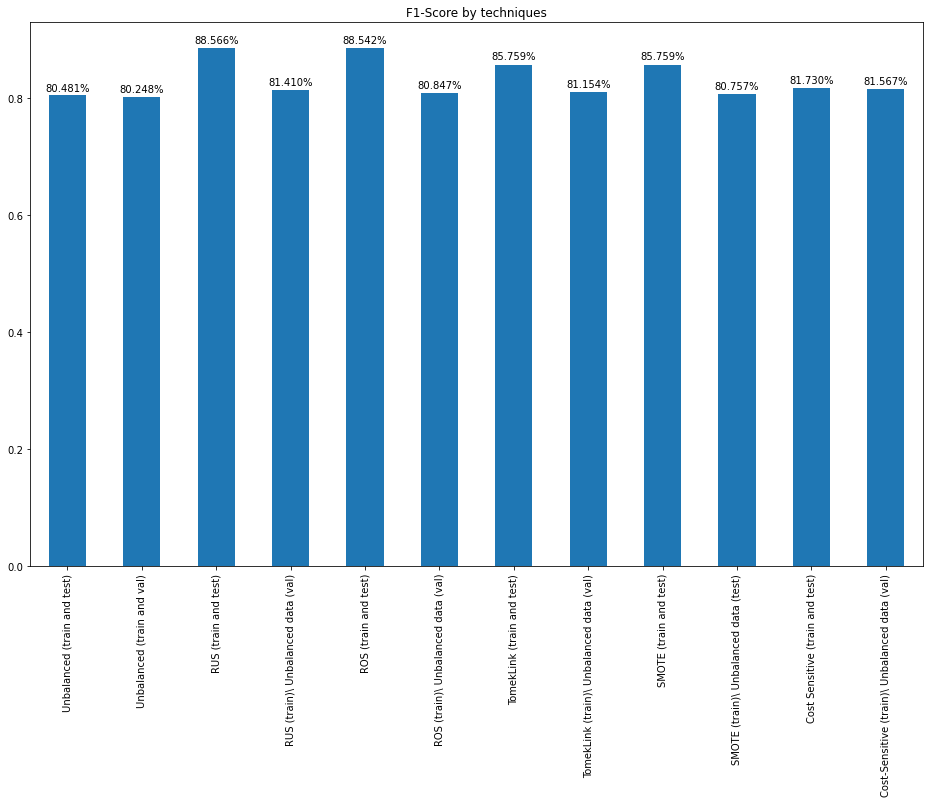

In [267]:
plt.figure(figsize=(16,10))
ax = results['F1-Score'].plot(kind='bar')
ax.set(title='F1-Score by techniques')
    
for p in ax.patches:
    (ax.annotate('{:.3f}%'.format(p.get_height()*100), 
                 (p.get_x() +  p.get_width()/2, p.get_y() + p.get_height()*1.01), ha='center'))
 
plt.xticks(np.arange(len(results['Technique'])), results['Technique'] , rotation=90)
plt.show()

We can see that all tests performed on models trained with balanced data work better than with the unbalanced set. Testing with the validation data, the best score was for the Cost Sensitive technique followed by Random Under Sampling, but as the difference for the other very small ones we could choose others.

# **Conclusions**

In this notebook we explore the data made available by BPI Challenge 2017 in order to practice knowledge of data analysis, exploratory data analysis, machine learning, among others, especially temporal data.

We analyze some data per week, amount of application, average of events per application and among others.

We tested some classifiers to predict whether an application would be completed in the current week. And we tested some techniques for balancing data from classes that answered True or False to this forecasting problem.

For better results in the classification we can improve the balance of the data, improve the division of the training and test sets, improve the features, test new classifiers or parameters, among others.

The analyzes were carried out during studies to practice the knowledge of the acquired area, for more interpretations and decisions, more in-depth analyzes should be carried out.
For the main purpose of the notebook, the result was satisfactory.